In [95]:
import matplotlib
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import geopandas as gpd

Import Data

In [2]:
def parse_data(given_path):
    file_name = 'metars_cache_1.csv'
    metars_path = os.path.join(given_path, file_name)
    metars_data = pd.read_csv(metars_path)
    return metars_data

In [17]:
save_path = os.path.abspath(os.path.join(os.pardir, 'data'))
given_data = parse_data(save_path)

display(given_data)

,raw_text,station_id,observation_time,latitude,longitude,temp_c,dewpoint_c,wind_dir_degrees,wind_speed_kt,wind_gust_kt,...,maxT24hr_c,minT24hr_c,precip_in,pcp3hr_in,pcp6hr_in,pcp24hr_in,snow_in,vert_vis_ft,metar_type,elevation_m
0,KBCT 220253Z 35007KT 10SM VCTS BKN050 22/17 A3...,KBCT,2022-10-22T02:53:00Z,26.38,-80.10,22.0,17.0,350.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,3.0
1,YSNF 220252Z AUTO 09007KT 9999 -SHRA SCT020 SC...,YSNF,2022-10-22T02:52:00Z,-29.03,167.93,18.0,16.0,90.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPECI,113.0
2,YCOM 220252Z AUTO 01013KT 5000 // SCT013 SCT02...,YCOM,2022-10-22T02:52:00Z,-36.30,148.97,NaN,NaN,10.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPECI,930.0
3,PAFM 220252Z AUTO 12003KT 10SM FEW004 SCT015 O...,PAFM,2022-10-22T02:52:00Z,67.10,-157.85,1.0,0.0,120.0,3.0,NaN,...,NaN,NaN,0.005,NaN,NaN,NaN,NaN,NaN,SPECI,79.0
4,PABV 220252Z AUTO 05003KT 10SM BKN004 02/02 A2...,PABV,2022-10-22T02:52:00Z,61.42,-149.52,2.0,2.0,50.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPECI,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4680,MMIA 220140Z 00000KT 6SM BKN100 23/22 A3000 RM...,MMIA,2022-10-22T01:40:00Z,19.27,-103.57,23.0,22.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,744.0
4681,MMHO 220140Z 24004KT 10SM SKC 29/17 A2984 RMK HZY,MMHO,2022-10-22T01:40:00Z,29.08,-111.05,29.0,17.0,240.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,186.0
4682,MMGM 220140Z 20006KT 10SM SKC 30/24 A2976,MMGM,2022-10-22T01:40:00Z,27.95,-110.92,30.0,24.0,200.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,13.0
4683,MMEP 220140Z 00000KT 8SM BKN020 23/20 A3000 RM...,MMEP,2022-10-22T01:40:00Z,21.42,-104.85,23.0,20.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,METAR,921.0


In [21]:
# Do some basic cleaning to get rid of rows that are missing lat/long, since that's the bare minimum we need
cleaned_data = given_data.dropna(axis=0, subset=['latitude', 'longitude'])
cleaned_data = cleaned_data.reset_index(drop=True)

Data Plots

In [110]:
def plot_map(df: pd.DataFrame, title: str, region: str=None, xtitle: str = None, ytitle: str = None,
    color_var: str = None, cmap: str = None, elim_outliers: bool = False) -> None:
    """
    Takes in a subset of the data, applies relevant titles, and provides the option of visualizing variations in a 
    particular quantity using a colorbar

    ---

    Notes about certain inputs:
    region - a string that's supposed to be either "world" or "usa"
    """
    # If no region is specified, default to the world
    if not region:
        region = 'world'
    
    # Get the appropriate map file. This segment is inspired by https://towardsdatascience.com/easiest-way-to-plot-on-a-world-map-with-pandas-and-geopandas-325f6024949f
    if region == 'usa':
        # For ease of use, we're excluding Hawaii and Alaska
        map = gpd.read_file(os.path.abspath(os.path.join(os.pardir, 'maps', 'USMap', 's_22mr22.shp')))
        map = map[map.STATE != 'AK']
        map = map[map.STATE != 'HI']
    else:
        map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    fig, ax = plt.subplots(figsize=(12, 6))
    map.plot(color="lightgrey", ax=ax)

    # If color_var was specified, then reassign itself to the series corresponding to df[color_var]
    if color_var:
        # Specifically clean based on this row to remove NaN values
        df = df.dropna(axis=0, subset=[color_var])
        df = df.reset_index(drop=True)

        # Remove outliers that are more than 3 standard dev's away from the mean
        # Based on https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe
        if elim_outliers:
            # This is off by default
            df = df[(np.abs(stats.zscore(df[color_var])) < 3)]

        color_var_data = df[color_var]

    plt.scatter(df['longitude'], df['latitude'], s=1, c=color_var_data, cmap=cmap)
    if color_var:
        plt.colorbar(label=color_var)

    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)

    # If the region was the US, apply axis limits
    if region == 'usa':
        plt.xlim([-125, -65])
        plt.ylim([24, 50])

    plt.show()

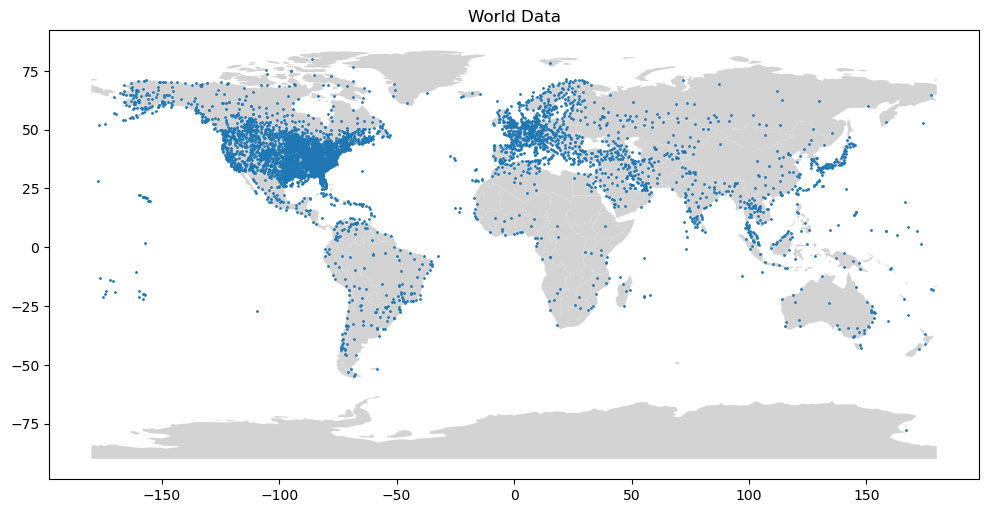

In [57]:
# Plot the data as is on the world map, just to visualize what it looks like and how it's distributed
plot_map(cleaned_data, "World Data")

In [75]:
def filter_usa(df: pd.DataFrame) -> pd.DataFrame:
    """Takes in world data and crudely restricts to just lat/long values corresponding to the lower 48"""

    # We'll be using latitude bounds of [24, 49] and longitude bounds of [-125, -67] based on https://www.findlatitudeandlongitude.com/l/Lower+48/4315442/
    return df.loc[(df['latitude'] >= 24) & (df['latitude'] <= 49) & (df['longitude'] >= -125) & (df['longitude'] <= -67)]

# Get a rough estimate of the data corresponding to the US (minus Alaska and Hawaii)
usa_data = filter_usa(cleaned_data)

# Also, because 'Murica, let's change the units from C to F
usa_data['temp_f'] = usa_data['temp_c'].apply(lambda x: (x * (9.0 / 5.0) + 32))
usa_data['dewpoint_f'] = usa_data['dewpoint_c'].apply(lambda x: (x * (9.0 / 5.0) + 32))

C:\Users\aksha\AppData\Local\Temp\ipykernel_14740\1828625642.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data['temp_f'] = usa_data['temp_c'].apply(lambda x: (x * (9.0 / 5.0) + 32))
C:\Users\aksha\AppData\Local\Temp\ipykernel_14740\1828625642.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data['dewpoint_f'] = usa_data['dewpoint_c'].apply(lambda x: (x * (9.0 / 5.0) + 32))


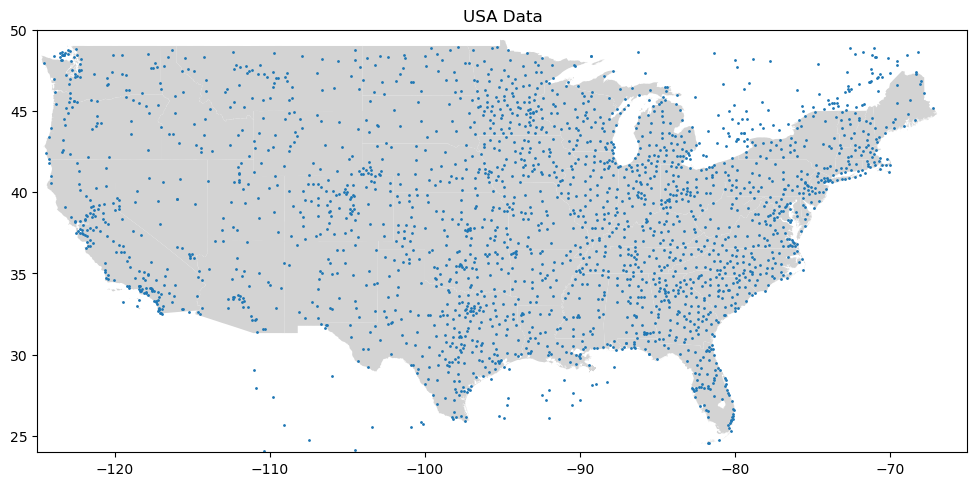

In [64]:
# Plot the data roughly corresponding to the US
plot_map(usa_data, 'USA Data', region='usa')

## Feature Graphs

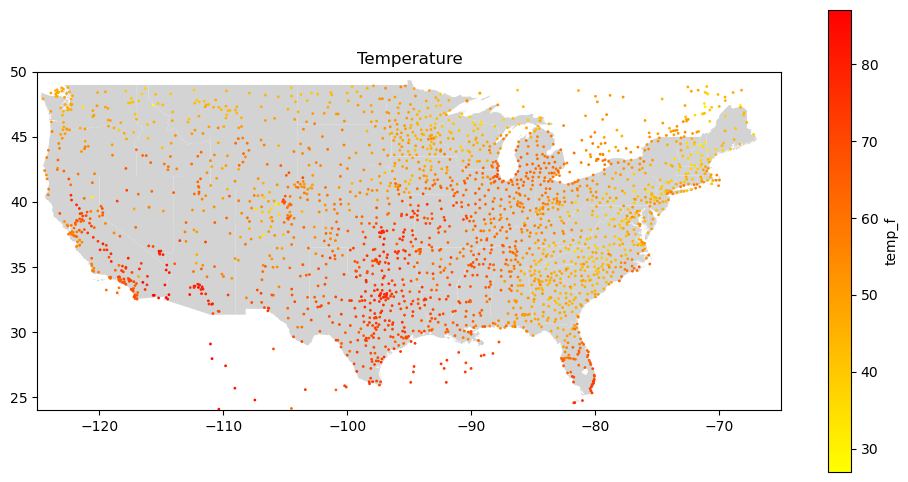

In [111]:
plot_map(usa_data, 'Temperature', region='usa', color_var='temp_f', cmap='autumn_r')

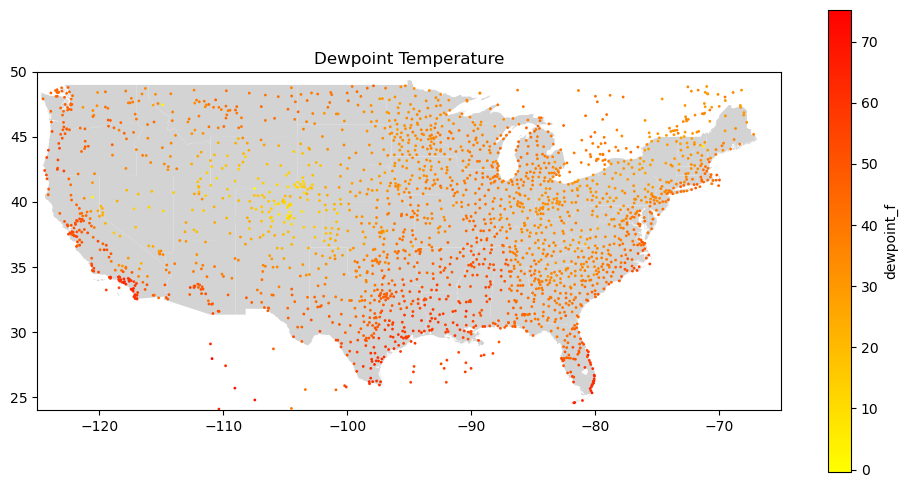

In [112]:
plot_map(usa_data, 'Dewpoint Temperature', region='usa', color_var='dewpoint_f', cmap='autumn_r')

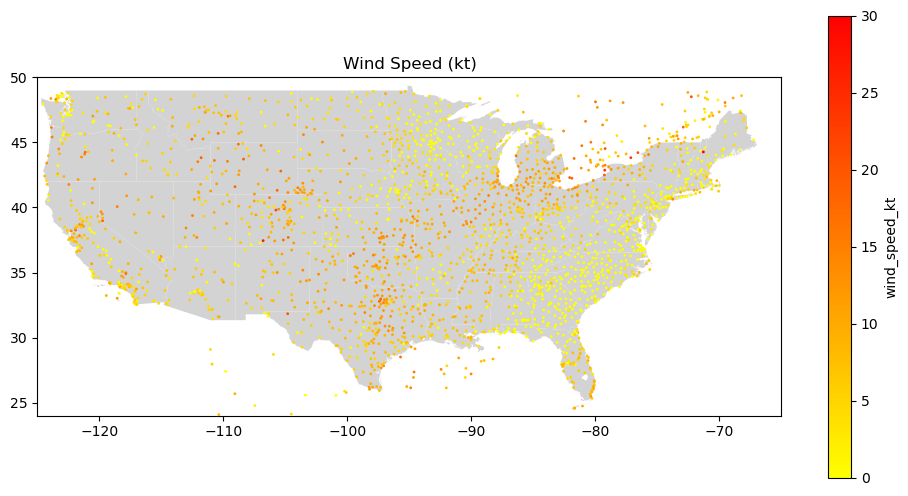

In [113]:
plot_map(usa_data, 'Wind Speed (kt)', region='usa', color_var='wind_speed_kt', cmap='autumn_r')

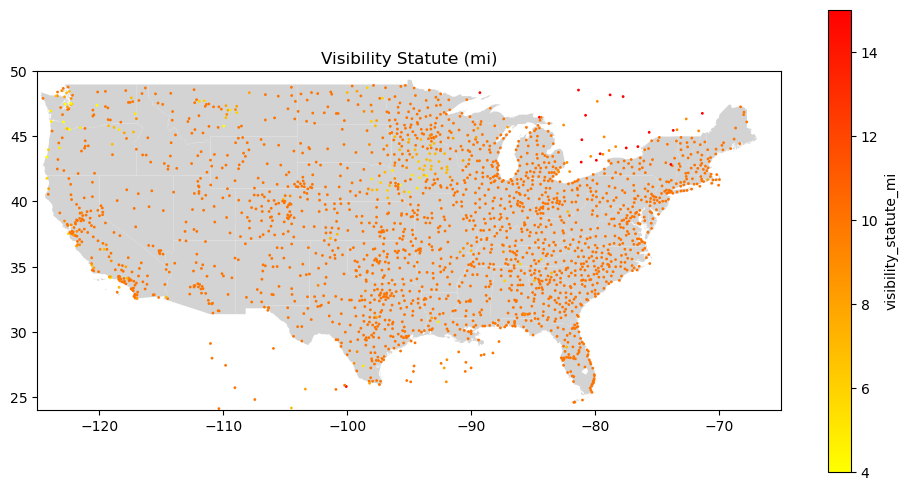

In [114]:
plot_map(usa_data, 'Visibility Statute (mi)', region='usa', color_var='visibility_statute_mi', cmap='autumn_r', elim_outliers=True)

In [125]:
pd.options.mode.chained_assignment = None 
# Let's explore the altitude data
usa_data['alt_ft'] = 1000 * (29.12 - 0.91*usa_data['altim_in_hg'])
print("Mean", usa_data['alt_ft'].mean())
print("Max", usa_data['alt_ft'].max())
print('Min', usa_data['alt_ft'].min())

Mean 1928.4121824802464
Max 5979.488059999998
Min 1610.4142599999989
